This notebook tests the predictions of the semi-physical model built for the L1 pump lasers with real data measured in the lab. 

Author: Francesco Capuano, 2022 S17 summer intern @ ELI-beamlines, Prague

All the different signals can be identified using the following diagram:
![](img/semi-physical_model.png)

In particular, this notebook focuses on analysing, given a precise control $\psi = \big(d_2, d_3, d_4\big) $ and input spectrum $E(\nu)$:
1. The difference between the predicted spectrum $y_3(\nu \vert \psi)$ and the one that is actually reconstructed at the FROG level, when the very same $\psi$ is applied at the stretcher level. 

2. The difference between the predicted temporal profile $y'(t \vert \psi)$ and the one that is reconstructed by the FROG, once more with the very same $\psi$. 

The goal of this analysis is establishing how good the semi-physical model, whose parametrization is exhaustively contained in $\chi = \big(B, \alpha_{GDD}, \alpha_{TOD}, \alpha_{FOD}\big)$, approximates the actual L1 pump laser. 

Signigicant discrepancies for what concerns the prediction can be due only to (non mutually exclusive) reasons: 

1) The $\chi$ used is a very poor approximation of the real $\chi_{LAB}$

2) The structure of the model is too simplistic/complex and does not capture the real underlying evolution of the phenomenon considered. 

In [1]:
# these import are necessary to import modules from directories one level back in the folder structure
import sys
sys.path.append("..")

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import c

from utils.LaserModel import LaserModel

In [2]:
data_path = "../data/L1_pump_spectrum.csv"
# read the data
df = pd.read_csv(data_path, header = None)
df.columns = ["Wavelength (nm)", "Intensity"]
# converting Wavelength in Frequency
df["Frequency (THz)"] = df["Wavelength (nm)"].apply(lambda wavelenght: 1e-12 * (c/(wavelenght * 1e-9)))
# clipping everything that is negative
df["Intensity"] = df["Intensity"].apply(lambda intensity: np.clip(intensity, a_min = 0, a_max = None))
# the observations must be returned for increasing values of frequency
df = df.sort_values(by = "Frequency (THz)")

frequency, intensity = df.loc[:, "Frequency (THz)"].values, df.loc[:, "Intensity"].values
intensity = (intensity - intensity.min()) / (intensity.max() - intensity.min())

lm = LaserModel(frequency = frequency, 
                intensity = intensity, 
                cutoff = (289.95, 291.91), 
                num_points_padding=int(5e2),
                num_points = int(5e2),
                # chi
                B = 2,
                compressor_params = -1 * np.array((267.422 * 1e-24, -2.384 * 1e-36, 9.54893 * 1e-50))
)

lm.preprocessing()

At first what is measured is the level of discrepancy between the spectrum reconstructed by the FROG algorithm and the one predicted by the semi-physical model. 


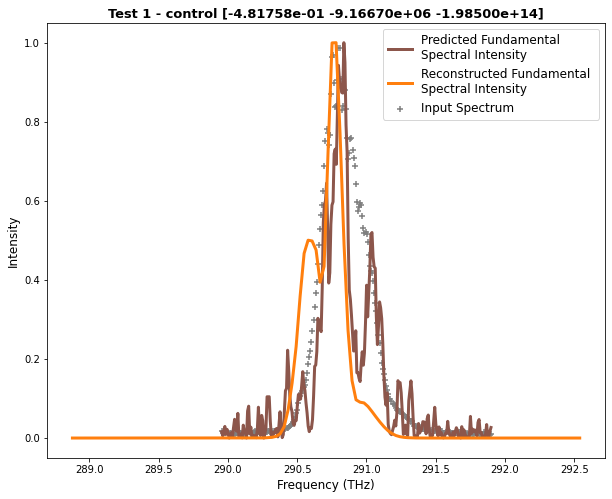

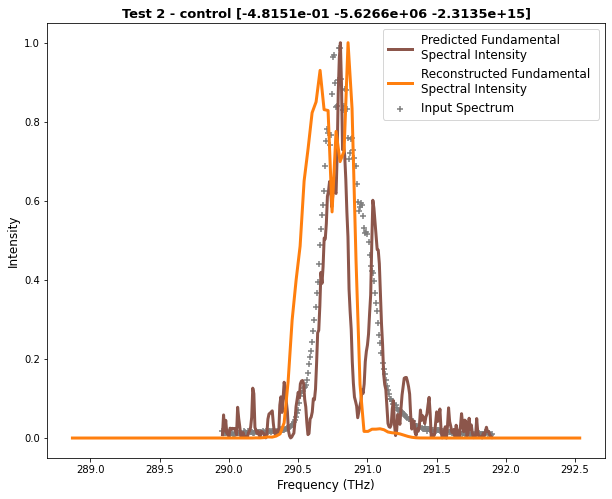

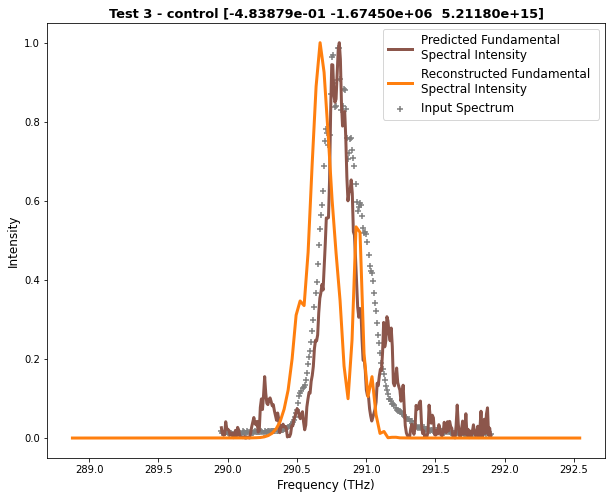

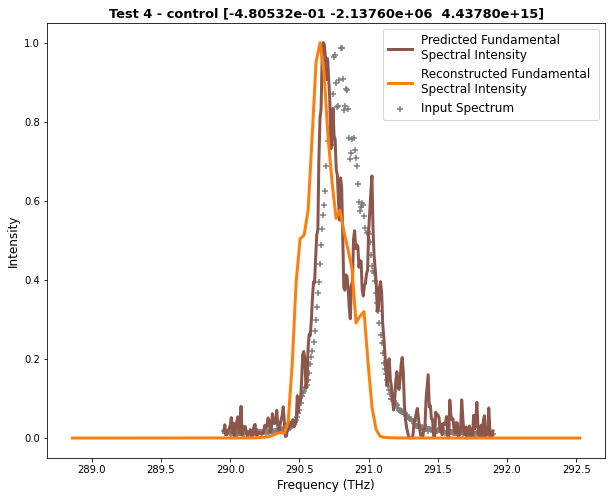

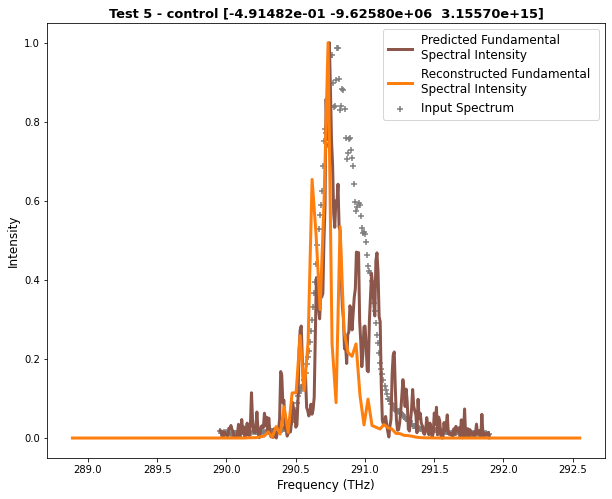

In [19]:
try: 
    os.chdir("../data/L1PumpData/")
except: 
    pass

# not in GDD, TOD and FOD but in d2, d3 and d4
controls = np.array([
    [-481.758 * 1e-3, -9.1667 * 1e6, -0.1985 * 1e15], 
    [-481.510 * 1e-3, -5.6266 * 1e6, -2.3135 * 1e15], 
    [-483.879 * 1e-3, -1.6745 * 1e6, +5.2118 * 1e15], 
    [-480.532 * 1e-3, -2.1376 * 1e6, +4.4378 * 1e15], 
    [-491.482 * 1e-3, -9.6258 * 1e6, +3.1557 * 1e15]
])

for idx in range(1, 6): 
    fig, ax = plt.subplots(figsize = (10,8))
    
    spectral_df = pd.read_csv(f"config{idx}_Retrieval_Spectral-Profile&Phase.csv", delimiter = ";")
    spectral_df["Frequency (THz)"] = spectral_df["Wavelength (nm)"].apply(lambda wl: 1e-12 * (c / (wl * 1e-9)))
    
    y3_frequency, y3_intensity = (spectral_df["Frequency (THz)"].values,
                              spectral_df["Spectral intensity (arb. u.)"].values
                             )
    
    performed_control = controls[idx - 1, :]
    
    lm.y1 = lm.stretcher(performed_control)
    lm.y2 = lm.DIRA()
    lm.y3 = lm.compressor()
    
    intensity_preFrog = np.real(lm.y3 * np.conj(lm.y3))
    intensity_preFrog = intensity_preFrog / intensity_preFrog.max()
    
    ax.plot(lm.frequency * 1e-12, intensity_preFrog, label = "Predicted Fundamental \nSpectral Intensity", lw = 3, color = "tab:brown")
    ax.plot(y3_frequency, y3_intensity , label = "Reconstructed Fundamental \nSpectral Intensity", lw = 3, color = "tab:orange")
        
    ax.scatter(lm.frequency * 1e-12, lm.field ** 2, label = "Input Spectrum", marker = "+", c = "tab:grey")
    
    ax.legend(fontsize = 12)
    ax.set_title(f"Test {idx} - control {performed_control}", fontweight = "bold", fontsize = 13)
    ax.set_xlabel("Frequency (THz)" ,fontsize = 12); ax.set_ylabel("Intensity" ,fontsize = 12)

In [4]:
lm = LaserModel(frequency = frequency, 
                intensity = intensity, 
                cutoff = (289.95, 291.91), 
                num_points = 250,
                num_points_padding = 1000,
                B = 2,
                compressor_params = -1 * np.array((267.422 * 1e-24, -2.384 * 1e-36, 9.54893 * 1e-50))
)

lm.preprocessing()

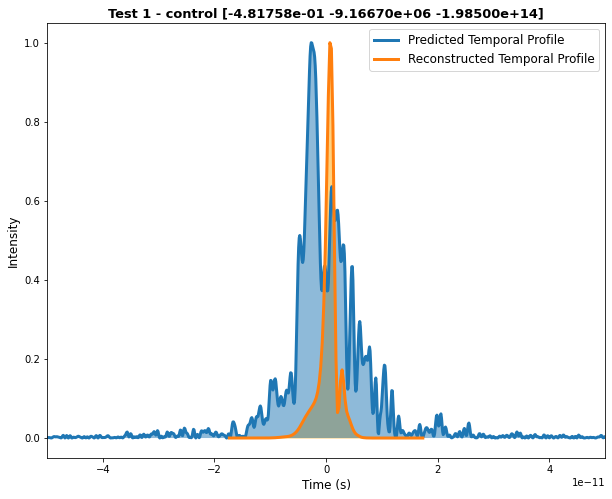

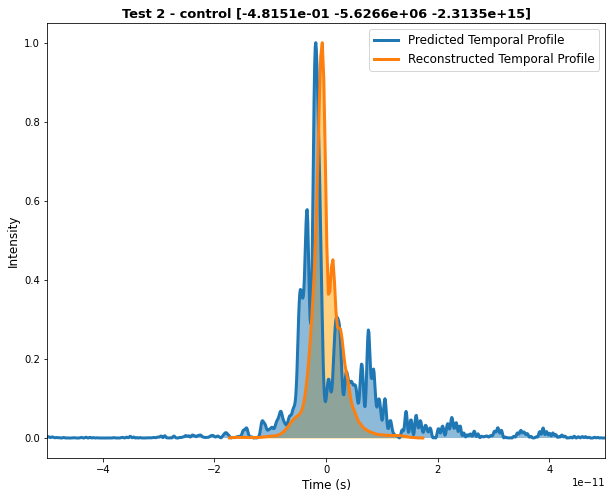

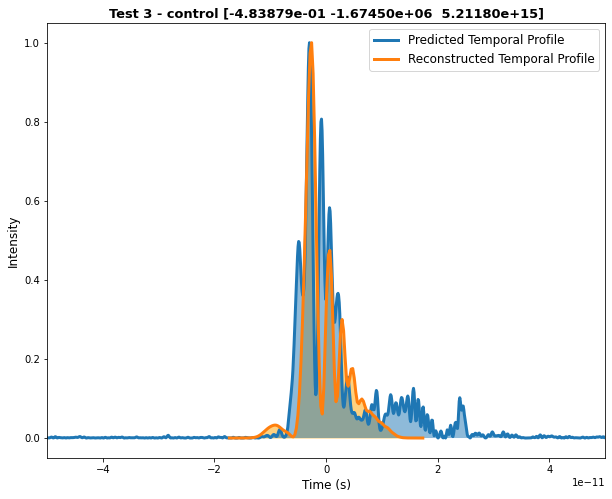

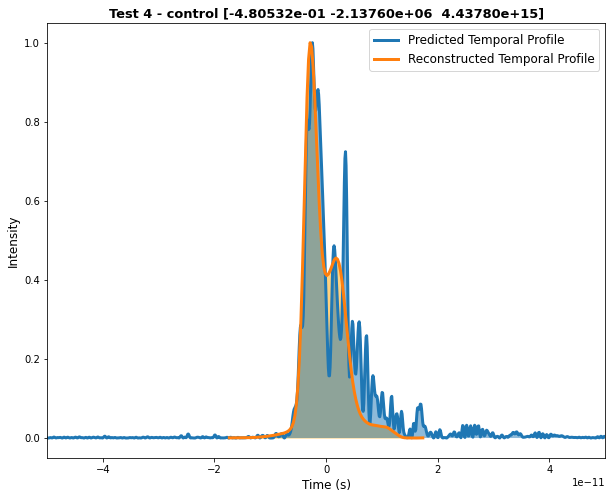

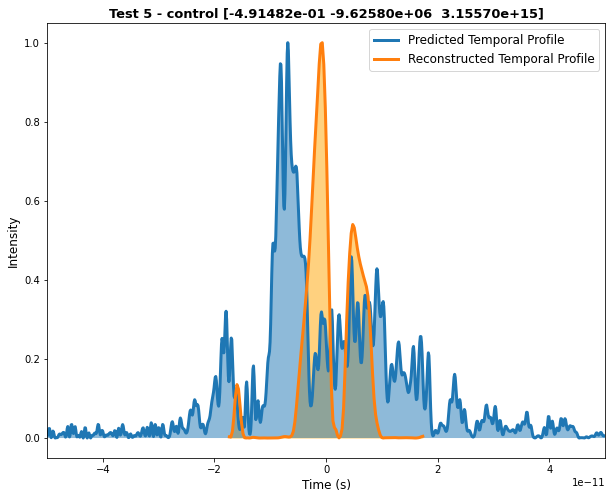

In [5]:
try: 
    os.chdir("../data/L1PumpData/")
except: 
    pass

controls = np.array([
    [-481.758 * 1e-3, -9.1667 * 1e6, -0.1985 * 1e15], 
    [-481.510 * 1e-3, -5.6266 * 1e6, -2.3135 * 1e15], 
    [-483.879 * 1e-3, -1.6745 * 1e6, +5.2118 * 1e15], 
    [-480.532 * 1e-3, -2.1376 * 1e6, +4.4378 * 1e15], 
    [-491.482 * 1e-3, -9.6258 * 1e6, +3.1557 * 1e15]
])

for idx in range(1, 6): 
    fig, ax = plt.subplots(figsize = (10,8))
    
    temporal_df = pd.read_csv(f"config{idx}_Retrieval_Temporal-Profile&Phase.csv", delimiter = ";")
    
    y3_time, y3_intensity_time = (temporal_df["Time (fs)"].values * 1e-15, 
                                  temporal_df["Temporal profile (arb. u.)"].values)
    
    performed_control = controls[idx - 1, :]
    
    predicted_time, predicted_profile = lm.forward_pass(performed_control)
    
    ax.plot(-1 * predicted_time, predicted_profile, label = "Predicted Temporal Profile", lw = 3)
    ax.plot(y3_time, y3_intensity_time, label = "Reconstructed Temporal Profile", lw = 3)
    
    ax.legend(fontsize = 12)
    
    ax.fill_between(y3_time, np.zeros_like(y3_time), y3_intensity_time, alpha=.5, linewidth=0, color = "orange")
    ax.fill_between(-1 * predicted_time, np.zeros_like(predicted_time), predicted_profile, alpha=.5, linewidth=0)
    
    ax.set_title(f"Test {idx} - control {performed_control}", fontweight = "bold", fontsize = 13)
    ax.set_xlabel("Time (s)" ,fontsize = 12); ax.set_ylabel("Intensity" ,fontsize = 12)
    
    ax.set_xlim(-0.5e-10, 0.5e-10)

Moreover, the following full-width half-maximum have been observed during the reconstruction of the temporal profile for the given $\psi$:

1. 1.70 (ps)
1. 3.4 (ps)
1. 3.94 (ps)
1. 4.1 (ps)
1. 4.3 (ps)